# McHacks 26 - Bot or Not

### Imports

In [62]:
import numpy as np
import matplotlib as plt
from pathlib import Path
import json
import pandas as pd
import re
from transformers import AutoTokenizer
from sklearn.preprocessing import StandardScaler

### Data processing

In [63]:
DATA_DIR = Path("data")

def get_version(path):
    try:
        return int(path.stem.split(".")[-1])
    except ValueError:
        return None

posts_users_files = sorted(DATA_DIR.glob("dataset.posts&users.*.json"), key=get_version)
if not posts_users_files:
    raise FileNotFoundError("No dataset.posts&users.*.json files found in data/")

combined = {}
bots_by_lang = {}

for path in posts_users_files:
    with path.open() as f:
        data = json.load(f)
    lang = data.get("lang")

    combined.setdefault(lang, {"posts": [], "users": [], "sources": []})
    combined[lang]["posts"].extend(data.get("posts", []))
    combined[lang]["users"].extend(data.get("users", []))
    combined[lang]["sources"].append(path.name)

    version = get_version(path)
    if version is not None:
        bots_path = DATA_DIR / f"dataset.bots.{version}.txt"
        if bots_path.exists():
            bots_by_lang.setdefault(lang, set()).update(bots_path.read_text().splitlines())

posts_en = pd.DataFrame(combined.get("en", {}).get("posts", []))
users_en = pd.DataFrame(combined.get("en", {}).get("users", []))
bot_ids_en = bots_by_lang.get("en", set())
if not users_en.empty:
    users_en["is_bot"] = users_en["id"].isin(bot_ids_en)

posts_fr = pd.DataFrame(combined.get("fr", {}).get("posts", []))
users_fr = pd.DataFrame(combined.get("fr", {}).get("users", []))
bot_ids_fr = bots_by_lang.get("fr", set())
if not users_fr.empty:
    users_fr["is_bot"] = users_fr["id"].isin(bot_ids_fr)

print("EN sources:", combined.get("en", {}).get("sources", []))
print(f"EN posts: {len(posts_en):,} users: {len(users_en):,} bot_ids: {len(bot_ids_en):,}")
print("FR sources:", combined.get("fr", {}).get("sources", []))
print(f"FR posts: {len(posts_fr):,} users: {len(users_fr):,} bot_ids: {len(bot_ids_fr):,}")


EN sources: ['dataset.posts&users.30.json', 'dataset.posts&users.32.json']
EN posts: 15,765 users: 546 bot_ids: 129
FR sources: ['dataset.posts&users.31.json', 'dataset.posts&users.33.json']
FR posts: 9,004 users: 343 bot_ids: 55


### Experiment parameters

In [64]:
EXPERIMENT_CONFIG = {
    "tokenizer_name": "vinai/bertweet-base",
    "max_length": 96,
    "dedupe_users": True,
    "dedupe_posts": True,
    "scale_meta_features": True,
    "use_topic_features": True,
    "topic_match_mode": "word",  # options: "contains", "word"
    "test_size": 0.20,
    "random_seed": 42,
    "validation_split": 0.15,
    "epochs": 8,
    "batch_size": 128,
    "learning_rate": 0.001,
    "prediction_threshold": 0.62,
    "use_threshold_search": True,
    "threshold_search_min": 0.10,
    "threshold_search_max": 0.90,
    "threshold_search_steps": 161,
    "account_decision_rule": "mean",  # options: "mean", "any"
    "split_by_author": True,
    "ensemble_seeds": [13, 29, 42, 73, 101],
    "ensemble_aggregation": "mean",  # options: "mean", "median"
    "use_second_stage_account_model": True,
    "second_stage_learning_rate": 0.05,
    "second_stage_max_iter": 300,
    "second_stage_max_depth": 4,
    "second_stage_l2": 0.2,
    "second_stage_use_balanced_weights": True,
    "use_class_weights": False,
    "embedding_dim": 96,
    "gru_units": 48,
    "aux_dense_units": 32,
    "head_dense_units": 48,
    "dropout_text": 0.40,
    "dropout_aux": 0.30,
    "dropout_head": 0.40,
    "early_stopping_patience": 1,
    "reduce_lr_patience": 1,
    "reduce_lr_factor": 0.50,
    "reduce_lr_min_lr": 1e-5,
}

print("Experiment config loaded:")
for key, value in EXPERIMENT_CONFIG.items():
    print(f"- {key}: {value}")


Experiment config loaded:
- tokenizer_name: vinai/bertweet-base
- max_length: 96
- dedupe_users: True
- dedupe_posts: True
- scale_meta_features: True
- use_topic_features: True
- topic_match_mode: word
- test_size: 0.2
- random_seed: 42
- validation_split: 0.15
- epochs: 8
- batch_size: 128
- learning_rate: 0.001
- prediction_threshold: 0.62
- use_threshold_search: True
- threshold_search_min: 0.1
- threshold_search_max: 0.9
- threshold_search_steps: 161
- account_decision_rule: mean
- split_by_author: True
- ensemble_seeds: [13, 29, 42, 73, 101]
- ensemble_aggregation: mean
- use_second_stage_account_model: True
- second_stage_learning_rate: 0.05
- second_stage_max_iter: 300
- second_stage_max_depth: 4
- second_stage_l2: 0.2
- second_stage_use_balanced_weights: True
- use_class_weights: False
- embedding_dim: 96
- gru_units: 48
- aux_dense_units: 32
- head_dense_units: 48
- dropout_text: 0.4
- dropout_aux: 0.3
- dropout_head: 0.4
- early_stopping_patience: 1
- reduce_lr_patience: 1
-

### Tokenizing the text

In [65]:
import re

try:
    from transformers import AutoTokenizer
except ImportError as exc:
    raise ImportError("Install transformers first: pip install transformers") from exc

from sklearn.preprocessing import StandardScaler

if "EXPERIMENT_CONFIG" not in globals():
    raise ValueError("Run the Experiment parameters cell first.")

TOKENIZER_NAME = str(EXPERIMENT_CONFIG["tokenizer_name"])
MAX_LENGTH = int(EXPERIMENT_CONFIG["max_length"])
DEDUPE_USERS = bool(EXPERIMENT_CONFIG["dedupe_users"])
DEDUPE_POSTS = bool(EXPERIMENT_CONFIG["dedupe_posts"])
SCALE_META_FEATURES = bool(EXPERIMENT_CONFIG["scale_meta_features"])

def clean_text(text):
    if not isinstance(text, str):
        return ""
    text = text.replace("\n", " ").strip()
    text = re.sub(r"\s+", " ", text)
    return text

def add_text_features(df):
    out = df.copy()
    out["text_clean"] = out["text"].fillna("").map(clean_text)
    out["char_count"] = out["text_clean"].str.len()
    out["word_count"] = out["text_clean"].str.split().str.len()
    out["url_count"] = out["text_clean"].str.count(r"https?://\S+|www\.\S+")
    out["mention_count"] = out["text_clean"].str.count(r"@\w+")
    out["hashtag_count"] = out["text_clean"].str.count(r"#\w+")
    out["exclamation_count"] = out["text_clean"].str.count(r"!")
    out["question_count"] = out["text_clean"].str.count(r"\?")
    return out

if posts_en.empty or users_en.empty:
    raise ValueError("Run the data processing cell first to load English data.")

users_en_labeled = (
    users_en.drop_duplicates(subset="id", keep="last").copy()
    if DEDUPE_USERS
    else users_en.copy()
)
posts_en_unique = (
    posts_en.drop_duplicates(subset="id", keep="last").copy()
    if DEDUPE_POSTS
    else posts_en.copy()
)

label_map_en = users_en_labeled.set_index("id")["is_bot"]
train_en = posts_en_unique.copy()
train_en["is_bot"] = train_en["author_id"].map(label_map_en)
train_en = train_en.dropna(subset=["is_bot"]).copy()
train_en["is_bot"] = train_en["is_bot"].astype("int64")

train_en = add_text_features(train_en)

tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_NAME, use_fast=True)
encodings_en = tokenizer(
    train_en["text_clean"].tolist(),
    truncation=True,
    padding="max_length",
    max_length=MAX_LENGTH,
    return_attention_mask=True,
)

feature_cols_en = [
    "char_count",
    "word_count",
    "url_count",
    "mention_count",
    "hashtag_count",
    "exclamation_count",
    "question_count",
]
X_meta_en = train_en[feature_cols_en].to_numpy(dtype=np.float32)
y_en = train_en["is_bot"].to_numpy(dtype=np.int64)

if SCALE_META_FEATURES:
    scaler_en = StandardScaler()
    X_meta_en_scaled = scaler_en.fit_transform(X_meta_en).astype(np.float32)
else:
    scaler_en = None
    X_meta_en_scaled = X_meta_en.copy()

print(f"Tokenizer: {TOKENIZER_NAME}")
print(f"English labeled posts: {len(train_en):,}")
print(f"Token tensor shape: {np.asarray(encodings_en['input_ids']).shape}")
print(f"Meta feature shape: {X_meta_en_scaled.shape}, label shape: {y_en.shape}")
print(f"Dedupe users/posts: {DEDUPE_USERS}/{DEDUPE_POSTS}")
print(f"Scale metadata features: {SCALE_META_FEATURES}")


Tokenizer: vinai/bertweet-base
English labeled posts: 15,765
Token tensor shape: (15765, 96)
Meta feature shape: (15765, 7), label shape: (15765,)
Dedupe users/posts: True/True
Scale metadata features: True


## Train-Test split for model

In [66]:
import re

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

try:
    import tensorflow as tf
except ImportError as exc:
    raise ImportError("Install tensorflow first: pip install tensorflow") from exc

if "EXPERIMENT_CONFIG" not in globals():
    raise ValueError("Run the Experiment parameters cell first.")

TEST_SIZE = float(EXPERIMENT_CONFIG["test_size"])
RANDOM_SEED = int(EXPERIMENT_CONFIG["random_seed"])
VALIDATION_SPLIT = float(EXPERIMENT_CONFIG["validation_split"])
EPOCHS = int(EXPERIMENT_CONFIG["epochs"])
BATCH_SIZE = int(EXPERIMENT_CONFIG["batch_size"])
LEARNING_RATE = float(EXPERIMENT_CONFIG["learning_rate"])
PREDICTION_THRESHOLD = float(EXPERIMENT_CONFIG["prediction_threshold"])
USE_CLASS_WEIGHTS = bool(EXPERIMENT_CONFIG["use_class_weights"])
USE_TOPIC_FEATURES = bool(EXPERIMENT_CONFIG["use_topic_features"])
TOPIC_MATCH_MODE = str(EXPERIMENT_CONFIG["topic_match_mode"])
SPLIT_BY_AUTHOR = bool(EXPERIMENT_CONFIG.get("split_by_author", True))

USE_THRESHOLD_SEARCH = bool(EXPERIMENT_CONFIG.get("use_threshold_search", False))
THRESHOLD_SEARCH_MIN = float(EXPERIMENT_CONFIG.get("threshold_search_min", 0.10))
THRESHOLD_SEARCH_MAX = float(EXPERIMENT_CONFIG.get("threshold_search_max", 0.90))
THRESHOLD_SEARCH_STEPS = int(EXPERIMENT_CONFIG.get("threshold_search_steps", 81))
ACCOUNT_DECISION_RULE = str(EXPERIMENT_CONFIG.get("account_decision_rule", "mean"))

EMBEDDING_DIM = int(EXPERIMENT_CONFIG["embedding_dim"])
GRU_UNITS = int(EXPERIMENT_CONFIG["gru_units"])
AUX_DENSE_UNITS = int(EXPERIMENT_CONFIG["aux_dense_units"])
HEAD_DENSE_UNITS = int(EXPERIMENT_CONFIG["head_dense_units"])
DROPOUT_TEXT = float(EXPERIMENT_CONFIG["dropout_text"])
DROPOUT_AUX = float(EXPERIMENT_CONFIG["dropout_aux"])
DROPOUT_HEAD = float(EXPERIMENT_CONFIG["dropout_head"])

EARLY_STOPPING_PATIENCE = int(EXPERIMENT_CONFIG["early_stopping_patience"])
REDUCE_LR_PATIENCE = int(EXPERIMENT_CONFIG["reduce_lr_patience"])
REDUCE_LR_FACTOR = float(EXPERIMENT_CONFIG["reduce_lr_factor"])
REDUCE_LR_MIN_LR = float(EXPERIMENT_CONFIG["reduce_lr_min_lr"])

if not (0.0 < TEST_SIZE < 1.0):
    raise ValueError("test_size must be between 0 and 1.")
if not (0.0 <= VALIDATION_SPLIT < 1.0):
    raise ValueError("validation_split must be in [0, 1).")
if TOPIC_MATCH_MODE not in {"contains", "word"}:
    raise ValueError('topic_match_mode must be "contains" or "word".')
if ACCOUNT_DECISION_RULE not in {"mean", "any"}:
    raise ValueError('account_decision_rule must be "mean" or "any".')
if USE_THRESHOLD_SEARCH:
    if not (0.0 < THRESHOLD_SEARCH_MIN < 1.0 and 0.0 < THRESHOLD_SEARCH_MAX < 1.0):
        raise ValueError("threshold_search_min and threshold_search_max must be in (0, 1).")
    if THRESHOLD_SEARCH_MIN >= THRESHOLD_SEARCH_MAX:
        raise ValueError("threshold_search_min must be smaller than threshold_search_max.")
    if THRESHOLD_SEARCH_STEPS < 2:
        raise ValueError("threshold_search_steps must be >= 2.")


def load_english_topic_keywords():
    topic_keywords = {}
    for source_name in combined.get("en", {}).get("sources", []):
        source_path = DATA_DIR / source_name
        with source_path.open() as f:
            payload = json.load(f)
        for topic_item in payload.get("metadata", {}).get("topics", []):
            topic = str(topic_item.get("topic", "")).strip().lower()
            if not topic:
                continue
            keywords = {
                str(keyword).strip().lower()
                for keyword in topic_item.get("keywords", [])
                if str(keyword).strip()
            }
            keywords.add(topic)
            topic_keywords.setdefault(topic, set()).update(keywords)
    return {topic: sorted(values, key=len, reverse=True) for topic, values in topic_keywords.items()}


def add_topic_features(df, topic_keywords, match_mode):
    out = df.copy()
    text_lower = out["text_clean"].str.lower()
    topic_cols = []
    for topic, keywords in topic_keywords.items():
        col = f"topic_{topic}"
        topic_cols.append(col)
        if not keywords:
            out[col] = 0
            continue
        if match_mode == "word":
            pattern = "|".join(rf"\\b{re.escape(keyword)}\\b" for keyword in keywords)
        else:
            pattern = "|".join(re.escape(keyword) for keyword in keywords)
        out[col] = text_lower.str.contains(pattern, regex=True).astype(np.int8)
    return out, topic_cols


def compute_account_score(author_ids, true_labels, pred_probs, threshold, decision_rule):
    tmp = pd.DataFrame(
        {
            "author_id": author_ids,
            "true_is_bot": np.asarray(true_labels, dtype=np.int64),
            "pred_prob": np.asarray(pred_probs, dtype=np.float32),
        }
    )
    tmp["pred_post"] = (tmp["pred_prob"] >= threshold).astype(np.int64)

    account = (
        tmp.groupby("author_id", as_index=False)
        .agg(
            true_is_bot=("true_is_bot", "max"),
            mean_prob=("pred_prob", "mean"),
            any_pred=("pred_post", "max"),
        )
    )

    if decision_rule == "any":
        account["pred_is_bot"] = account["any_pred"].astype(np.int64)
    else:
        account["pred_is_bot"] = (account["mean_prob"] >= threshold).astype(np.int64)

    tp_accounts = int(((account["true_is_bot"] == 1) & (account["pred_is_bot"] == 1)).sum())
    fn_accounts = int(((account["true_is_bot"] == 1) & (account["pred_is_bot"] == 0)).sum())
    fp_accounts = int(((account["true_is_bot"] == 0) & (account["pred_is_bot"] == 1)).sum())

    score = (4 * tp_accounts) - (1 * fn_accounts) - (2 * fp_accounts)
    return score, tp_accounts, fn_accounts, fp_accounts, len(account)


def predict_for_indices(model, post_indices):
    if len(post_indices) == 0:
        return np.array([], dtype=np.float32)
    return model.predict(
        {
            "input_ids": input_ids_en[post_indices],
            "attention_mask": attention_mask_en[post_indices],
            "aux_features": X_aux_en[post_indices],
        },
        verbose=0,
    ).ravel()


if USE_TOPIC_FEATURES:
    topic_keywords_en = load_english_topic_keywords()
    train_en_model, topic_feature_cols_en = add_topic_features(train_en, topic_keywords_en, TOPIC_MATCH_MODE)
else:
    train_en_model = train_en.copy()
    topic_feature_cols_en = []

input_ids_en = np.asarray(encodings_en["input_ids"], dtype=np.int32)
attention_mask_en = np.asarray(encodings_en["attention_mask"], dtype=np.float32)
X_topic_en = (
    train_en_model[topic_feature_cols_en].to_numpy(dtype=np.float32)
    if topic_feature_cols_en
    else np.zeros((len(train_en_model), 0), dtype=np.float32)
)
X_aux_en = np.concatenate([X_meta_en_scaled, X_topic_en], axis=1)

all_post_idx = np.arange(len(y_en))

if SPLIT_BY_AUTHOR:
    author_labels_df = (
        train_en_model.groupby("author_id", as_index=False)["is_bot"]
        .max()
        .rename(columns={"is_bot": "account_is_bot"})
    )
    all_authors = author_labels_df["author_id"].to_numpy()
    all_author_labels = author_labels_df["account_is_bot"].to_numpy(dtype=np.int64)

    train_authors, test_authors = train_test_split(
        all_authors,
        test_size=TEST_SIZE,
        random_state=RANDOM_SEED,
        stratify=all_author_labels,
    )

    if VALIDATION_SPLIT > 0:
        train_author_labels = (
            author_labels_df.set_index("author_id").loc[train_authors, "account_is_bot"].to_numpy(dtype=np.int64)
        )
        fit_authors, val_authors = train_test_split(
            train_authors,
            test_size=VALIDATION_SPLIT,
            random_state=RANDOM_SEED,
            stratify=train_author_labels,
        )
    else:
        fit_authors = train_authors
        val_authors = np.array([], dtype=all_authors.dtype)

    fit_author_set = set(fit_authors.tolist())
    val_author_set = set(val_authors.tolist())
    test_author_set = set(test_authors.tolist())

    fit_idx = np.flatnonzero(train_en_model["author_id"].isin(fit_author_set).to_numpy())
    val_idx = np.flatnonzero(train_en_model["author_id"].isin(val_author_set).to_numpy())
    test_idx = np.flatnonzero(train_en_model["author_id"].isin(test_author_set).to_numpy())
    split_mode = "author"
else:
    train_idx, test_idx = train_test_split(
        all_post_idx,
        test_size=TEST_SIZE,
        random_state=RANDOM_SEED,
        stratify=y_en,
    )

    if VALIDATION_SPLIT > 0:
        fit_idx, val_idx = train_test_split(
            train_idx,
            test_size=VALIDATION_SPLIT,
            random_state=RANDOM_SEED,
            stratify=y_en[train_idx],
        )
    else:
        fit_idx = train_idx
        val_idx = np.array([], dtype=np.int64)

    split_mode = "post"

X_fit_ids, X_test_ids = input_ids_en[fit_idx], input_ids_en[test_idx]
X_fit_mask, X_test_mask = attention_mask_en[fit_idx], attention_mask_en[test_idx]
X_fit_aux, X_test_aux = X_aux_en[fit_idx], X_aux_en[test_idx]
y_fit, y_test = y_en[fit_idx], y_en[test_idx]

X_val_ids = input_ids_en[val_idx] if len(val_idx) else None
X_val_mask = attention_mask_en[val_idx] if len(val_idx) else None
X_val_aux = X_aux_en[val_idx] if len(val_idx) else None
y_val = y_en[val_idx] if len(val_idx) else None

fit_author_ids = np.unique(train_en_model.iloc[fit_idx]["author_id"].to_numpy())
val_author_ids = np.unique(train_en_model.iloc[val_idx]["author_id"].to_numpy()) if len(val_idx) else np.array([])
test_author_ids = np.unique(train_en_model.iloc[test_idx]["author_id"].to_numpy())

class_weight_dict = None
if USE_CLASS_WEIGHTS:
    classes = np.unique(y_fit)
    class_weights = compute_class_weight(class_weight="balanced", classes=classes, y=y_fit)
    class_weight_dict = {int(c): float(w) for c, w in zip(classes, class_weights)}


def build_multifeature_model(
    vocab_size,
    seq_len,
    aux_dim,
    embedding_dim,
    gru_units,
    aux_dense_units,
    head_dense_units,
    dropout_text,
    dropout_aux,
    dropout_head,
    learning_rate,
):
    ids_input = tf.keras.layers.Input(shape=(seq_len,), dtype="int32", name="input_ids")
    mask_input = tf.keras.layers.Input(shape=(seq_len,), dtype="float32", name="attention_mask")
    aux_input = tf.keras.layers.Input(shape=(aux_dim,), dtype="float32", name="aux_features")

    x = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="token_embedding")(ids_input)
    mask = tf.keras.layers.Reshape((seq_len, 1))(mask_input)
    x = tf.keras.layers.Multiply()([x, mask])
    x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(gru_units))(x)
    x = tf.keras.layers.Dropout(dropout_text)(x)

    aux = tf.keras.layers.Dense(aux_dense_units, activation="relu")(aux_input)
    aux = tf.keras.layers.Dropout(dropout_aux)(aux)

    merged = tf.keras.layers.Concatenate()([x, aux])
    merged = tf.keras.layers.Dense(head_dense_units, activation="relu")(merged)
    merged = tf.keras.layers.Dropout(dropout_head)(merged)
    output = tf.keras.layers.Dense(1, activation="sigmoid")(merged)

    model = tf.keras.Model(inputs=[ids_input, mask_input, aux_input], outputs=output)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss="binary_crossentropy",
        metrics=[tf.keras.metrics.BinaryAccuracy(name="accuracy"), tf.keras.metrics.AUC(name="auc")],
    )
    return model


model_en = build_multifeature_model(
    vocab_size=tokenizer.vocab_size,
    seq_len=MAX_LENGTH,
    aux_dim=X_fit_aux.shape[1],
    embedding_dim=EMBEDDING_DIM,
    gru_units=GRU_UNITS,
    aux_dense_units=AUX_DENSE_UNITS,
    head_dense_units=HEAD_DENSE_UNITS,
    dropout_text=DROPOUT_TEXT,
    dropout_aux=DROPOUT_AUX,
    dropout_head=DROPOUT_HEAD,
    learning_rate=LEARNING_RATE,
)

has_validation = len(val_idx) > 0
callbacks = []
if has_validation and EARLY_STOPPING_PATIENCE > 0:
    callbacks.append(
        tf.keras.callbacks.EarlyStopping(
            monitor="val_auc",
            mode="max",
            patience=EARLY_STOPPING_PATIENCE,
            restore_best_weights=True,
        )
    )
if has_validation and REDUCE_LR_PATIENCE > 0:
    callbacks.append(
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor="val_auc",
            mode="max",
            factor=REDUCE_LR_FACTOR,
            patience=REDUCE_LR_PATIENCE,
            min_lr=REDUCE_LR_MIN_LR,
        )
    )

train_inputs = {
    "input_ids": X_fit_ids,
    "attention_mask": X_fit_mask,
    "aux_features": X_fit_aux,
}

fit_kwargs = {
    "epochs": EPOCHS,
    "batch_size": BATCH_SIZE,
    "class_weight": class_weight_dict,
    "callbacks": callbacks,
    "verbose": 1,
}
if has_validation:
    fit_kwargs["validation_data"] = (
        {
            "input_ids": X_val_ids,
            "attention_mask": X_val_mask,
            "aux_features": X_val_aux,
        },
        y_val,
    )

history_en = model_en.fit(train_inputs, y_fit, **fit_kwargs)

post_prob_fit = predict_for_indices(model_en, fit_idx)
post_prob_val = predict_for_indices(model_en, val_idx)
post_prob_test = predict_for_indices(model_en, test_idx)

y_prob = post_prob_test.copy()
threshold_search_results_en = pd.DataFrame()
SELECTED_THRESHOLD = PREDICTION_THRESHOLD
best_threshold_val_score = None

if has_validation and USE_THRESHOLD_SEARCH:
    val_author_ids_for_score = train_en_model.iloc[val_idx]["author_id"].to_numpy()
    search_rows = []
    for threshold in np.linspace(THRESHOLD_SEARCH_MIN, THRESHOLD_SEARCH_MAX, THRESHOLD_SEARCH_STEPS):
        score, tp_acc, fn_acc, fp_acc, n_accounts = compute_account_score(
            author_ids=val_author_ids_for_score,
            true_labels=y_val,
            pred_probs=post_prob_val,
            threshold=float(threshold),
            decision_rule=ACCOUNT_DECISION_RULE,
        )
        search_rows.append(
            {
                "threshold": float(threshold),
                "score": int(score),
                "tp_accounts": int(tp_acc),
                "fn_accounts": int(fn_acc),
                "fp_accounts": int(fp_acc),
                "n_accounts": int(n_accounts),
            }
        )

    threshold_search_results_en = pd.DataFrame(search_rows)
    best_row = threshold_search_results_en.sort_values(
        by=["score", "fp_accounts", "tp_accounts", "threshold"],
        ascending=[False, True, False, False],
    ).iloc[0]

    SELECTED_THRESHOLD = float(best_row["threshold"])
    best_threshold_val_score = int(best_row["score"])

y_pred = (y_prob >= SELECTED_THRESHOLD).astype(np.int64)

test_author_ids_for_score = train_en_model.iloc[test_idx]["author_id"].to_numpy()
(
    test_score,
    test_tp_accounts,
    test_fn_accounts,
    test_fp_accounts,
    test_n_accounts,
) = compute_account_score(
    author_ids=test_author_ids_for_score,
    true_labels=y_test,
    pred_probs=y_prob,
    threshold=SELECTED_THRESHOLD,
    decision_rule=ACCOUNT_DECISION_RULE,
)

(
    baseline_test_score,
    baseline_tp_accounts,
    baseline_fn_accounts,
    baseline_fp_accounts,
    baseline_n_accounts,
) = compute_account_score(
    author_ids=test_author_ids_for_score,
    true_labels=y_test,
    pred_probs=y_prob,
    threshold=PREDICTION_THRESHOLD,
    decision_rule=ACCOUNT_DECISION_RULE,
)

print(f"Split mode: {split_mode}")
print(f"Topic features enabled: {USE_TOPIC_FEATURES}")
print(f"Topic match mode: {TOPIC_MATCH_MODE}")
print(f"Account decision rule: {ACCOUNT_DECISION_RULE}")
print("Topic columns:", topic_feature_cols_en)
print(f"Split sizes (fit/val/test posts): {len(fit_idx)}/{len(val_idx)}/{len(test_idx)}")
print(
    f"Split sizes (fit/val/test accounts): {len(fit_author_ids)}/{len(val_author_ids)}/{len(test_author_ids)}"
)
print(f"Default threshold from config: {PREDICTION_THRESHOLD:.4f}")
print(f"Selected threshold used on test: {SELECTED_THRESHOLD:.4f}")
if best_threshold_val_score is not None:
    print(f"Best validation score from threshold search: {best_threshold_val_score}")
print(f"Test Accuracy (post-level): {accuracy_score(y_test, y_pred):.4f}")
print(f"Test ROC-AUC (post-level): {roc_auc_score(y_test, y_prob):.4f}")
print(
    f"Test account score @ selected threshold -> score={test_score}, TP={test_tp_accounts}, FN={test_fn_accounts}, FP={test_fp_accounts}, accounts={test_n_accounts}"
)
print(
    f"Test account score @ config threshold -> score={baseline_test_score}, TP={baseline_tp_accounts}, FN={baseline_fn_accounts}, FP={baseline_fp_accounts}, accounts={baseline_n_accounts}"
)
print(classification_report(y_test, y_pred, digits=4))


Epoch 1/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7451 - auc: 0.7613 - loss: 0.5348 - val_accuracy: 0.8692 - val_auc: 0.8204 - val_loss: 0.3839 - learning_rate: 0.0010
Epoch 2/8
81/81 ━━━━━━━━━━━━━━━━━━━━ 9s 110ms/step - accuracy: 0.8964 - auc: 0.9100 - loss: 0.2980 - val_accuracy: 0.8707 - val_auc: 0.8105 - val_loss: 0.3998 - learning_rate: 0.0010
Split mode: author
Topic features enabled: True
Topic match mode: word
Account decision rule: mean
Topic columns: ['topic_pop', 'topic_nba', 'topic_movies', 'topic_nhl']
Split sizes (fit/val/test posts): 10318/2041/3406
Split sizes (fit/val/test accounts): 370/66/110
Default threshold from config: 0.6200
Selected threshold used on test: 0.2650
Best validation score from threshold search: 46
Test Accuracy (post-level): 0.8417
Test ROC-AUC (post-level): 0.8768
Test account score @ selected threshold -> score=62, TP=22, FN=4, FP=11, accounts=110
Test account score @ config threshold -> score=39, TP=13, FN=13, FP=0, accounts=110
 

## Bot-detector score

In [67]:
if any(name not in globals() for name in ["train_en_model", "test_idx", "y_prob", "PREDICTION_THRESHOLD"]):
    raise ValueError("Run the Train-Test split for model cell first.")

threshold_for_score = float(globals().get("SELECTED_THRESHOLD", PREDICTION_THRESHOLD))
if "ACCOUNT_DECISION_RULE" in globals():
    account_decision_rule = str(ACCOUNT_DECISION_RULE)
elif "EXPERIMENT_CONFIG" in globals():
    account_decision_rule = str(EXPERIMENT_CONFIG.get("account_decision_rule", "mean"))
else:
    account_decision_rule = "mean"

if account_decision_rule not in {"mean", "any"}:
    raise ValueError('account_decision_rule must be "mean" or "any".')

# Build test-set account labels/predictions from post-level outputs.
score_df = train_en_model.iloc[test_idx][["author_id", "is_bot"]].copy()
score_df["pred_prob"] = y_prob
score_df["pred_post"] = (score_df["pred_prob"] >= threshold_for_score).astype(np.int64)

account_df = (
    score_df.groupby("author_id", as_index=False)
    .agg(
        true_is_bot=("is_bot", "max"),
        mean_prob=("pred_prob", "mean"),
        any_pred=("pred_post", "max"),
        n_posts=("pred_post", "size"),
    )
)

if account_decision_rule == "any":
    account_df["pred_is_bot"] = account_df["any_pred"].astype(np.int64)
else:
    account_df["pred_is_bot"] = (account_df["mean_prob"] >= threshold_for_score).astype(np.int64)

tp_accounts = int(((account_df["true_is_bot"] == 1) & (account_df["pred_is_bot"] == 1)).sum())
fn_accounts = int(((account_df["true_is_bot"] == 1) & (account_df["pred_is_bot"] == 0)).sum())
fp_accounts = int(((account_df["true_is_bot"] == 0) & (account_df["pred_is_bot"] == 1)).sum())
tn_accounts = int(((account_df["true_is_bot"] == 0) & (account_df["pred_is_bot"] == 0)).sum())

score = (4 * tp_accounts) - (1 * fn_accounts) - (2 * fp_accounts)
max_possible_score = 4 * int((account_df["true_is_bot"] == 1).sum())
min_possible_score = (
    -1 * int((account_df["true_is_bot"] == 1).sum())
    -2 * int((account_df["true_is_bot"] == 0).sum())
)

score_ratio = score / max_possible_score if max_possible_score > 0 else np.nan
score_normalized = (
    (score - min_possible_score) / (max_possible_score - min_possible_score)
    if max_possible_score != min_possible_score
    else np.nan
)

print(f"Threshold used: {threshold_for_score:.4f}")
print(f"Account decision rule: {account_decision_rule}")
print(f"Accounts scored (test split): {len(account_df)}")
print(f"TP: {tp_accounts}  FN: {fn_accounts}  FP: {fp_accounts}  TN: {tn_accounts}")
print(f"Bot detector score: {score}")
print(f"Score out of max possible: {score}/{max_possible_score} ({score_ratio:.2%})")
print(f"Score range on this split: [{min_possible_score}, {max_possible_score}]")
print(f"Range-normalized score: {score_normalized:.2%}")

if "second_stage_test_score_en" in globals():
    print(
        f"Second-stage account-model score (recommended): {second_stage_test_score_en} at threshold {second_stage_selected_threshold_en:.4f}"
    )


Threshold used: 0.2650
Account decision rule: mean
Accounts scored (test split): 110
TP: 22  FN: 4  FP: 11  TN: 73
Bot detector score: 62
Score out of max possible: 62/104 (59.62%)
Score range on this split: [-194, 104]
Range-normalized score: 85.91%
Second-stage account-model score (recommended): 92 at threshold 0.7050


## Strongest booster (account-level second stage)

In [68]:
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, precision_score, recall_score

try:
    from catboost import CatBoostClassifier
except ImportError as exc:
    raise ImportError("Install catboost first: pip install catboost") from exc

required_globals = [
    "tf",
    "EXPERIMENT_CONFIG",
    "build_multifeature_model",
    "compute_account_score",
    "train_en_model",
    "topic_feature_cols_en",
    "fit_idx",
    "val_idx",
    "test_idx",
    "input_ids_en",
    "attention_mask_en",
    "X_aux_en",
    "y_en",
    "MAX_LENGTH",
    "tokenizer",
    "users_en",
    "EMBEDDING_DIM",
    "GRU_UNITS",
    "AUX_DENSE_UNITS",
    "HEAD_DENSE_UNITS",
    "DROPOUT_TEXT",
    "DROPOUT_AUX",
    "DROPOUT_HEAD",
    "LEARNING_RATE",
    "EPOCHS",
    "BATCH_SIZE",
    "RANDOM_SEED",
    "USE_CLASS_WEIGHTS",
    "class_weight_dict",
    "USE_THRESHOLD_SEARCH",
    "THRESHOLD_SEARCH_MIN",
    "THRESHOLD_SEARCH_MAX",
    "THRESHOLD_SEARCH_STEPS",
    "PREDICTION_THRESHOLD",
    "ACCOUNT_DECISION_RULE",
    "EARLY_STOPPING_PATIENCE",
    "REDUCE_LR_PATIENCE",
    "REDUCE_LR_FACTOR",
    "REDUCE_LR_MIN_LR",
]
missing = [name for name in required_globals if name not in globals()]
if missing:
    raise ValueError(f"Run the Train-Test split for model cell first. Missing: {missing}")

if ACCOUNT_DECISION_RULE not in {"mean", "any"}:
    raise ValueError('account_decision_rule must be "mean" or "any".')

ensemble_seeds_cfg = EXPERIMENT_CONFIG.get("ensemble_seeds", [RANDOM_SEED])
if isinstance(ensemble_seeds_cfg, (int, np.integer)):
    ensemble_seeds = [int(ensemble_seeds_cfg)]
elif isinstance(ensemble_seeds_cfg, (list, tuple)):
    ensemble_seeds = [int(seed) for seed in ensemble_seeds_cfg]
else:
    raise ValueError("ensemble_seeds must be an int or a list of ints.")
ensemble_seeds = list(dict.fromkeys(ensemble_seeds))
if not ensemble_seeds:
    raise ValueError("ensemble_seeds cannot be empty.")

ENSEMBLE_AGGREGATION = str(EXPERIMENT_CONFIG.get("ensemble_aggregation", "mean")).lower()
if ENSEMBLE_AGGREGATION not in {"mean", "median"}:
    raise ValueError('ensemble_aggregation must be "mean" or "median".')

USE_SECOND_STAGE_ACCOUNT_MODEL = bool(EXPERIMENT_CONFIG.get("use_second_stage_account_model", True))
SECOND_STAGE_LEARNING_RATE = float(EXPERIMENT_CONFIG.get("second_stage_learning_rate", 0.05))
SECOND_STAGE_MAX_ITER = int(EXPERIMENT_CONFIG.get("second_stage_max_iter", 300))
SECOND_STAGE_MAX_DEPTH = int(EXPERIMENT_CONFIG.get("second_stage_max_depth", 4))
SECOND_STAGE_L2 = float(EXPERIMENT_CONFIG.get("second_stage_l2", 0.2))
SECOND_STAGE_USE_BALANCED_WEIGHTS = bool(EXPERIMENT_CONFIG.get("second_stage_use_balanced_weights", True))

has_validation = len(val_idx) > 0
fit_author_ids_for_score = train_en_model.iloc[fit_idx]["author_id"].to_numpy()
val_author_ids_for_score = train_en_model.iloc[val_idx]["author_id"].to_numpy() if has_validation else np.array([])
test_author_ids_for_score = train_en_model.iloc[test_idx]["author_id"].to_numpy()


def _predict_post_probs(model, indices):
    if len(indices) == 0:
        return np.array([], dtype=np.float32)
    return model.predict(
        {
            "input_ids": input_ids_en[indices],
            "attention_mask": attention_mask_en[indices],
            "aux_features": X_aux_en[indices],
        },
        verbose=0,
    ).ravel()


def _build_callbacks():
    callbacks = []
    if has_validation and EARLY_STOPPING_PATIENCE > 0:
        callbacks.append(
            tf.keras.callbacks.EarlyStopping(
                monitor="val_auc",
                mode="max",
                patience=EARLY_STOPPING_PATIENCE,
                restore_best_weights=True,
            )
        )
    if has_validation and REDUCE_LR_PATIENCE > 0:
        callbacks.append(
            tf.keras.callbacks.ReduceLROnPlateau(
                monitor="val_auc",
                mode="max",
                factor=REDUCE_LR_FACTOR,
                patience=REDUCE_LR_PATIENCE,
                min_lr=REDUCE_LR_MIN_LR,
            )
        )
    return callbacks


def _search_best_threshold(author_ids, labels, probs):
    if not (has_validation and USE_THRESHOLD_SEARCH):
        return float(PREDICTION_THRESHOLD), None, pd.DataFrame()

    rows = []
    for threshold in np.linspace(THRESHOLD_SEARCH_MIN, THRESHOLD_SEARCH_MAX, THRESHOLD_SEARCH_STEPS):
        score, tp, fn, fp, n_accounts = compute_account_score(
            author_ids=author_ids,
            true_labels=labels,
            pred_probs=probs,
            threshold=float(threshold),
            decision_rule=ACCOUNT_DECISION_RULE,
        )
        rows.append(
            {
                "threshold": float(threshold),
                "score": int(score),
                "tp_accounts": int(tp),
                "fn_accounts": int(fn),
                "fp_accounts": int(fp),
                "n_accounts": int(n_accounts),
            }
        )

    df = pd.DataFrame(rows)
    best_row = df.sort_values(
        by=["score", "fp_accounts", "tp_accounts", "threshold"],
        ascending=[False, True, False, False],
    ).iloc[0]
    return float(best_row["threshold"]), int(best_row["score"]), df


fit_inputs = {
    "input_ids": input_ids_en[fit_idx],
    "attention_mask": attention_mask_en[fit_idx],
    "aux_features": X_aux_en[fit_idx],
}
val_inputs = (
    {
        "input_ids": input_ids_en[val_idx],
        "attention_mask": attention_mask_en[val_idx],
        "aux_features": X_aux_en[val_idx],
    }
    if has_validation
    else None
)

post_prob_fit_list = []
post_prob_val_list = []
post_prob_test_list = []
seed_rows = []

if hasattr(tf.config.experimental, "enable_op_determinism"):
    try:
        tf.config.experimental.enable_op_determinism()
    except Exception:
        pass

for seed in ensemble_seeds:
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(int(seed))
    np.random.seed(int(seed))

    model_seed = build_multifeature_model(
        vocab_size=tokenizer.vocab_size,
        seq_len=MAX_LENGTH,
        aux_dim=X_aux_en.shape[1],
        embedding_dim=EMBEDDING_DIM,
        gru_units=GRU_UNITS,
        aux_dense_units=AUX_DENSE_UNITS,
        head_dense_units=HEAD_DENSE_UNITS,
        dropout_text=DROPOUT_TEXT,
        dropout_aux=DROPOUT_AUX,
        dropout_head=DROPOUT_HEAD,
        learning_rate=LEARNING_RATE,
    )

    fit_kwargs = {
        "epochs": EPOCHS,
        "batch_size": BATCH_SIZE,
        "class_weight": class_weight_dict if USE_CLASS_WEIGHTS else None,
        "callbacks": _build_callbacks(),
        "verbose": 0,
    }
    if has_validation:
        fit_kwargs["validation_data"] = (val_inputs, y_en[val_idx])

    model_seed.fit(fit_inputs, y_en[fit_idx], **fit_kwargs)

    fit_probs = _predict_post_probs(model_seed, fit_idx)
    val_probs = _predict_post_probs(model_seed, val_idx)
    test_probs = _predict_post_probs(model_seed, test_idx)

    threshold_seed, val_score_seed, _ = _search_best_threshold(val_author_ids_for_score, y_en[val_idx], val_probs)

    test_score_seed, tp_seed, fn_seed, fp_seed, n_accounts_seed = compute_account_score(
        author_ids=test_author_ids_for_score,
        true_labels=y_en[test_idx],
        pred_probs=test_probs,
        threshold=threshold_seed,
        decision_rule=ACCOUNT_DECISION_RULE,
    )

    seed_rows.append(
        {
            "seed": int(seed),
            "threshold": float(threshold_seed),
            "val_best_score": val_score_seed,
            "test_score": int(test_score_seed),
            "tp_accounts": int(tp_seed),
            "fn_accounts": int(fn_seed),
            "fp_accounts": int(fp_seed),
            "n_accounts": int(n_accounts_seed),
        }
    )

    post_prob_fit_list.append(fit_probs)
    post_prob_val_list.append(val_probs)
    post_prob_test_list.append(test_probs)

seed_report_df = pd.DataFrame(seed_rows)
ensemble_seed_report_en = seed_report_df.copy()

def _aggregate_probabilities(prob_list, mode):
    if not prob_list:
        return np.array([], dtype=np.float32)
    stack = np.vstack(prob_list)
    if mode == "median":
        return np.median(stack, axis=0).astype(np.float32)
    return np.mean(stack, axis=0).astype(np.float32)

post_prob_fit_ensemble_en = _aggregate_probabilities(post_prob_fit_list, ENSEMBLE_AGGREGATION)
post_prob_val_ensemble_en = _aggregate_probabilities(post_prob_val_list, ENSEMBLE_AGGREGATION)
post_prob_test_ensemble_en = _aggregate_probabilities(post_prob_test_list, ENSEMBLE_AGGREGATION)

selected_threshold_ensemble, best_ensemble_val_score, threshold_search_results_ensemble_en = _search_best_threshold(
    val_author_ids_for_score,
    y_en[val_idx],
    post_prob_val_ensemble_en,
)

(
    test_score_ensemble_en,
    ensemble_tp_accounts_en,
    ensemble_fn_accounts_en,
    ensemble_fp_accounts_en,
    ensemble_n_accounts_en,
) = compute_account_score(
    author_ids=test_author_ids_for_score,
    true_labels=y_en[test_idx],
    pred_probs=post_prob_test_ensemble_en,
    threshold=selected_threshold_ensemble,
    decision_rule=ACCOUNT_DECISION_RULE,
)

# Make the ensemble outputs the default baseline for downstream score/plot cells.
post_prob_fit = post_prob_fit_ensemble_en
post_prob_val = post_prob_val_ensemble_en
post_prob_test = post_prob_test_ensemble_en
y_prob = post_prob_test_ensemble_en
SELECTED_THRESHOLD = float(selected_threshold_ensemble)
test_score = int(test_score_ensemble_en)
test_tp_accounts = int(ensemble_tp_accounts_en)
test_fn_accounts = int(ensemble_fn_accounts_en)
test_fp_accounts = int(ensemble_fp_accounts_en)
test_n_accounts = int(ensemble_n_accounts_en)

seed_mean_score_en = float(seed_report_df["test_score"].mean())
seed_std_score_en = float(seed_report_df["test_score"].std(ddof=1)) if len(seed_report_df) > 1 else 0.0


def build_account_feature_table(post_indices, post_probs, bot_threshold):
    posts = train_en_model.iloc[post_indices].copy()
    posts["post_prob"] = np.asarray(post_probs, dtype=np.float32)

    posts["has_url_post"] = (posts["url_count"] > 0).astype(np.float32)
    posts["has_mention_post"] = (posts["mention_count"] > 0).astype(np.float32)
    posts["has_hashtag_post"] = (posts["hashtag_count"] > 0).astype(np.float32)
    posts["pred_bot_post"] = (posts["post_prob"] >= bot_threshold).astype(np.float32)

    agg_spec = {
        "is_bot": ["max"],
        "text_clean": ["size"],
        "post_prob": ["mean", "std", "max", "min"],
        "char_count": ["mean", "std", "max"],
        "word_count": ["mean", "std", "max"],
        "url_count": ["mean", "max"],
        "mention_count": ["mean", "max"],
        "hashtag_count": ["mean", "max"],
        "exclamation_count": ["mean", "max"],
        "question_count": ["mean", "max"],
        "has_url_post": ["mean"],
        "has_mention_post": ["mean"],
        "has_hashtag_post": ["mean"],
        "pred_bot_post": ["mean"],
    }

    for topic_col in topic_feature_cols_en:
        agg_spec[topic_col] = ["mean"]

    account = posts.groupby("author_id", as_index=False).agg(agg_spec)
    account.columns = [
        "author_id" if col == ("author_id", "") else f"{col[0]}_{col[1]}"
        for col in account.columns.to_flat_index()
    ]

    account = account.rename(columns={"is_bot_max": "true_is_bot", "text_clean_size": "n_posts"})
    for col in ["post_prob_std", "char_count_std", "word_count_std"]:
        if col in account.columns:
            account[col] = account[col].fillna(0.0)
    account["n_posts_log1p"] = np.log1p(account["n_posts"].astype(np.float32))

    user_source = (
        users_en_labeled.copy()
        if "users_en_labeled" in globals()
        else users_en.drop_duplicates(subset="id", keep="last").copy()
    )
    user_source["username_len"] = user_source["username"].fillna("").str.len()
    user_source["name_len"] = user_source["name"].fillna("").str.len()
    user_source["description_len"] = user_source["description"].fillna("").str.len()
    user_source["has_location"] = user_source["location"].fillna("").str.strip().ne("").astype(np.float32)

    user_features = user_source[
        [
            "id",
            "tweet_count",
            "z_score",
            "username_len",
            "name_len",
            "description_len",
            "has_location",
        ]
    ].copy()

    account = account.merge(user_features, left_on="author_id", right_on="id", how="left").drop(columns=["id"])

    numeric_cols = [col for col in account.columns if col != "author_id"]
    account[numeric_cols] = account[numeric_cols].apply(pd.to_numeric, errors="coerce").fillna(0.0)
    return account


def score_from_account_probs(true_labels, pred_probs, threshold):
    pred_labels = (pred_probs >= threshold).astype(np.int64)
    tp = int(((true_labels == 1) & (pred_labels == 1)).sum())
    fn = int(((true_labels == 1) & (pred_labels == 0)).sum())
    fp = int(((true_labels == 0) & (pred_labels == 1)).sum())
    score = (4 * tp) - (1 * fn) - (2 * fp)
    return score, tp, fn, fp, pred_labels


if USE_SECOND_STAGE_ACCOUNT_MODEL:
    fit_account_df = build_account_feature_table(fit_idx, post_prob_fit_ensemble_en, selected_threshold_ensemble)
    val_account_df = (
        build_account_feature_table(val_idx, post_prob_val_ensemble_en, selected_threshold_ensemble)
        if has_validation
        else pd.DataFrame()
    )
    test_account_df = build_account_feature_table(test_idx, post_prob_test_ensemble_en, selected_threshold_ensemble)

    target_col = "true_is_bot"
    feature_cols_account = [col for col in fit_account_df.columns if col not in {"author_id", target_col}]

    for df in [fit_account_df, val_account_df, test_account_df]:
        if df.empty:
            continue
        missing_cols = [col for col in feature_cols_account if col not in df.columns]
        for col in missing_cols:
            df[col] = 0.0

    X_fit_acc = fit_account_df[feature_cols_account].to_numpy(dtype=np.float32)
    y_fit_acc = fit_account_df[target_col].to_numpy(dtype=np.int64)
    X_test_acc = test_account_df[feature_cols_account].to_numpy(dtype=np.float32)
    y_test_acc = test_account_df[target_col].to_numpy(dtype=np.int64)

    if len(val_account_df):
        X_val_acc = val_account_df[feature_cols_account].to_numpy(dtype=np.float32)
        y_val_acc = val_account_df[target_col].to_numpy(dtype=np.int64)
    else:
        X_val_acc = np.zeros((0, len(feature_cols_account)), dtype=np.float32)
        y_val_acc = np.zeros((0,), dtype=np.int64)

    catboost_kwargs = {
        "iterations": SECOND_STAGE_MAX_ITER,
        "learning_rate": SECOND_STAGE_LEARNING_RATE,
        "depth": SECOND_STAGE_MAX_DEPTH,
        "l2_leaf_reg": SECOND_STAGE_L2,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": RANDOM_SEED,
        "verbose": False,
    }
    if SECOND_STAGE_USE_BALANCED_WEIGHTS:
        catboost_kwargs["auto_class_weights"] = "Balanced"

    second_stage_model_en = CatBoostClassifier(**catboost_kwargs)

    fit_kwargs = {}
    if len(y_val_acc):
        fit_kwargs["eval_set"] = (X_val_acc, y_val_acc)
        fit_kwargs["use_best_model"] = True

    second_stage_model_en.fit(X_fit_acc, y_fit_acc, **fit_kwargs)

    second_stage_selected_threshold_en = float(selected_threshold_ensemble)
    second_stage_threshold_search_results_en = pd.DataFrame()

    if len(y_val_acc) and USE_THRESHOLD_SEARCH:
        val_prob_acc = second_stage_model_en.predict_proba(X_val_acc)[:, 1]
        rows = []
        for threshold in np.linspace(THRESHOLD_SEARCH_MIN, THRESHOLD_SEARCH_MAX, THRESHOLD_SEARCH_STEPS):
            score, tp, fn, fp, _ = score_from_account_probs(y_val_acc, val_prob_acc, float(threshold))
            rows.append(
                {
                    "threshold": float(threshold),
                    "score": int(score),
                    "tp_accounts": int(tp),
                    "fn_accounts": int(fn),
                    "fp_accounts": int(fp),
                }
            )
        second_stage_threshold_search_results_en = pd.DataFrame(rows)
        best_row = second_stage_threshold_search_results_en.sort_values(
            by=["score", "fp_accounts", "tp_accounts", "threshold"],
            ascending=[False, True, False, False],
        ).iloc[0]
        second_stage_selected_threshold_en = float(best_row["threshold"])

    second_stage_test_prob_en = second_stage_model_en.predict_proba(X_test_acc)[:, 1]
    (
        second_stage_test_score_en,
        second_stage_tp_accounts_en,
        second_stage_fn_accounts_en,
        second_stage_fp_accounts_en,
        second_stage_test_pred_en,
    ) = score_from_account_probs(y_test_acc, second_stage_test_prob_en, second_stage_selected_threshold_en)

    max_score_accounts = 4 * int((y_test_acc == 1).sum())
    second_stage_score_ratio_en = (
        second_stage_test_score_en / max_score_accounts if max_score_accounts > 0 else np.nan
    )

    second_stage_account_predictions_en = test_account_df[["author_id", target_col]].copy()
    second_stage_account_predictions_en["pred_prob"] = second_stage_test_prob_en
    second_stage_account_predictions_en["pred_is_bot"] = second_stage_test_pred_en

    # Make CatBoost second-stage score visible to downstream summary/plot cells.
    max_possible_score = max_score_accounts

print("Seed-level first-stage account scores (test):")
print(
    seed_report_df[
        [
            "seed",
            "threshold",
            "test_score",
            "tp_accounts",
            "fn_accounts",
            "fp_accounts",
        ]
    ].to_string(index=False)
)
print(f"Seed score mean/std: {seed_mean_score_en:.2f} / {seed_std_score_en:.2f}")
print(f"Ensemble aggregation: {ENSEMBLE_AGGREGATION}")
print(f"Ensemble selected threshold: {selected_threshold_ensemble:.4f}")
print(
    f"Ensemble test score: {test_score_ensemble_en} (TP={ensemble_tp_accounts_en}, FN={ensemble_fn_accounts_en}, FP={ensemble_fp_accounts_en}, accounts={ensemble_n_accounts_en})"
)

if USE_SECOND_STAGE_ACCOUNT_MODEL:
    print("Second-stage model: CatBoostClassifier")
    print(
        f"Second-stage threshold: {second_stage_selected_threshold_en:.4f}"
    )
    print(
        f"Second-stage test score: {second_stage_test_score_en}/{max_score_accounts} ({second_stage_score_ratio_en:.2%})"
    )
    print(
        f"Second-stage confusion components -> TP={second_stage_tp_accounts_en}, FN={second_stage_fn_accounts_en}, FP={second_stage_fp_accounts_en}"
    )
    print(
        f"Second-stage precision={precision_score(y_test_acc, second_stage_test_pred_en, zero_division=0):.4f}, "
        f"recall={recall_score(y_test_acc, second_stage_test_pred_en, zero_division=0):.4f}"
    )
    print(classification_report(y_test_acc, second_stage_test_pred_en, digits=4))
else:
    print("Second-stage account model disabled in EXPERIMENT_CONFIG.")


2026-02-08 16:51:40.532111: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
2026-02-08 16:51:50.027853: E tensorflow/core/framework/node_def_util.cc:680] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

Seed-level first-stage account scores (test):
 seed  threshold  test_score  tp_accounts  fn_accounts  fp_accounts
   13      0.335          72           20            6            1
   29      0.325          69           21            5            5
   42      0.520          49           15           11            0
   73      0.660          57           17            9            1
  101      0.380          66           20            6            4
Seed score mean/std: 62.60 / 9.45
Ensemble aggregation: mean
Ensemble selected threshold: 0.3700
Ensemble test score: 77 (TP=21, FN=5, FP=1, accounts=110)
Second-stage model: CatBoostClassifier
Second-stage threshold: 0.7900
Second-stage test score: 89/104 (85.58%)
Second-stage confusion components -> TP=23, FN=3, FP=0
Second-stage precision=1.0000, recall=0.8846
              precision    recall  f1-score   support

           0     0.9655    1.0000    0.9825        84
           1     1.0000    0.8846    0.9388        26

    accuracy    

## Final score plot

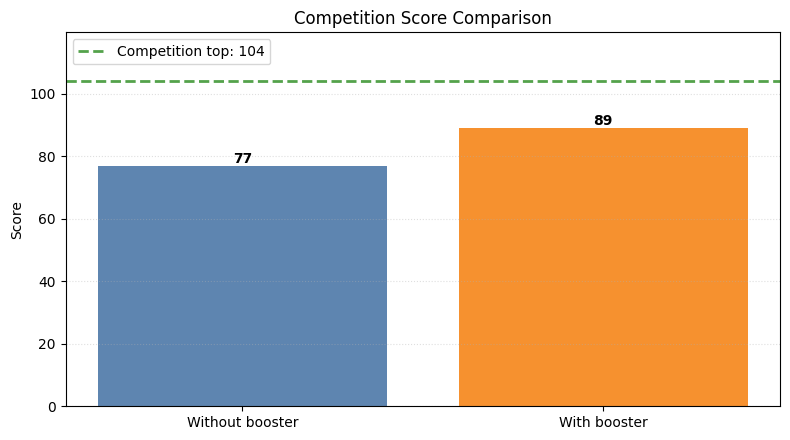

Without booster: 77
With booster: 89
Competition top (max possible on this split): 104


In [69]:
import matplotlib.pyplot as plt

if "train_en_model" not in globals() or "test_idx" not in globals():
    raise ValueError("Run the training cell first.")

score_without_booster = None
if "test_score" in globals():
    score_without_booster = float(test_score)
elif "score" in globals():
    score_without_booster = float(score)
else:
    raise ValueError("No baseline score found. Run the model scoring cells first.")

score_with_booster = float(second_stage_test_score_en) if "second_stage_test_score_en" in globals() else None

if "max_possible_score" in globals():
    competition_top = float(max_possible_score)
else:
    account_truth = (
        train_en_model.iloc[test_idx][["author_id", "is_bot"]]
        .groupby("author_id", as_index=False)["is_bot"]
        .max()
    )
    competition_top = float(4 * int(account_truth["is_bot"].sum()))

labels = ["Without booster"]
scores = [score_without_booster]
colors = ["#4c78a8"]

if score_with_booster is not None:
    labels.append("With booster")
    scores.append(score_with_booster)
    colors.append("#f58518")

fig, ax = plt.subplots(figsize=(8, 4.5))
bars = ax.bar(labels, scores, color=colors, alpha=0.9)
ax.axhline(competition_top, color="#54a24b", linestyle="--", linewidth=2, label=f"Competition top: {competition_top:.0f}")

for bar, value in zip(bars, scores):
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        value,
        f"{value:.0f}",
        ha="center",
        va="bottom",
        fontsize=10,
        fontweight="bold",
    )

ax.set_title("Competition Score Comparison")
ax.set_ylabel("Score")
ax.set_ylim(0, max(max(scores), competition_top) * 1.15)
ax.grid(axis="y", linestyle=":", alpha=0.4)
ax.legend(loc="upper left")

plt.tight_layout()
plt.show()

print(f"Without booster: {score_without_booster:.0f}")
if score_with_booster is not None:
    print(f"With booster: {score_with_booster:.0f}")
print(f"Competition top (max possible on this split): {competition_top:.0f}")
